In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
# https://stackoverflow.com/a/59337065
from warnings import filterwarnings
filterwarnings("ignore")

# Extract training data for image segmentation models from the Descartes Labs API

This notebook contains a workflow for extracting training data for image segmentation deep learning models from the Descartes Labs API. Authenticated access to the API is required to be able to use the code. 

## Output 

The training data we create consist of pairs of image tiles or "chips": One image, from a data product of interest (e.g. VHR RGB imagery) and one "label image" representing the class of each pixel in the corresponding image. 

The data are extracted into parallel subfolders called `images` and `labels` where each folder contains an identically-named set of GeoTIFF files.

The imagery chips have a number of bands and datatype that depends on the imagery product they're extracted from. The label chips are uint8 single-band images. 

The extent and resolution of each image chip is defined by a "[DLTile](https://docs.descarteslabs.com/descarteslabs/scenes/docs/geocontext.html#descarteslabs.scenes.geocontext.DLTile)". Each file has the name of the corresponding DLTile, except that (for filename requirements) the ':' character is replaced by '#'.

## Approach

The ground truth or labels data are defined externally in a GIS dataset. Features (normally polygons) should be created with an attribute that specifies the label of each polygon. The features should not overlap. This dataset should be created before running the code in this notebook.

We create image chips to cover all features in the given label dataset. The label pixels will have the value of the corresponding polygon (we "rasterise" the polygons). Any areas within an image chip that are not covered by any polygon will be given a specified background value.


## Implementation

The code necessary to perform these tasks is implemented in the dl_segmentation_utils package, and this notebook gives a run-through of using that code.

Import the necessary items from the package

In [1]:
from dl_segmentation_utils import OGRLabelDataDesc, DLSampleCreationConfig, create_chips_for_tile
from datetime import date
import os

The following imports are only needed for visualisation/demonstration within this notebook. If you are skipping straight to running the exports, you don't need these.

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from dl_segmentation_utils import create_label_array_for_tile, create_img_array_for_tile, create_cloudmasked_s2_array
import descarteslabs as dl

## Configure the sampling jobs

#### Loading the labels data

This notebook is loosely based on the DL Wellpads sample. This used GeoJSON and parsed it directly, and didn't use a classification attribute in the data (any polygon present was deemed to be wellpad (slum)).

Now we'll switch to using OGR to import any other suitable geographic data type. I'm using an ESRI file geodatabase but shapefiles (or indeed GeoJSON) will work equally well. `OGRLabelDataDesc` is a simple config object to hold the three parameters necessary to describe which data to use. Create one instance for each feature class of ground truth data that we have available

In [3]:
_gpkg = '/home/harry/lusaka_training_data.gpkg'

lusaka_labels = OGRLabelDataDesc(
    ogr_dataset = _gpkg,
    ogr_layer_name_or_idx = "all_tiles_all_classes_with_code",
    attrib_to_burn="class_code"
)

lusaka_locations = OGRLabelDataDesc(
    ogr_dataset = _gpkg,
    ogr_layer_name_or_idx = "training_bboxes"
)



For the rest of the notebook we'll just refer to THIS_RUN_LABELS so set that to point to whichever one we wish to use here

In [4]:
THIS_RUN_LABELS = lusaka_labels
THIS_RUN_LOCS = lusaka_locations

#### Create sampling job configurations

The `DLSampleCreationConfig` class defines the tile size, resolution and padding we want to export, the area for which we want to export it (in the form of an `OGRLabelDataDesc`), the Descartes Labs imagery product to export, and the location  where the images should be saved.

Create three instances, one for VHR RGB imagery from Airbus Pleiades, one for multispectral imagery from Sentinel-2, and another for RGB-only imagery from Sentinel-2.

Also create one further instance for retrieving model outputs that we have created and stored as products in the DL catalog. This one shows a different syntax where we provide multiple DL catalog product IDs. This will cause the image chip retrieval code to get data from all the mentioned products and stack it into the bands of a single image chip.

In [5]:
DLSampleCreationConfig?

Init signature:
DLSampleCreationConfig(
    tile_size,
    tile_padding,
    tile_res_m,
    dl_product,
    bands,
    sample_folder_root,
    source_tag,
    label_data_config: dl_segmentation_utils._descartes_img_chips.OGRLabelDataDesc,
    label_coverage_config: dl_segmentation_utils._descartes_img_chips.OGRLabelDataDesc = None,
    max_cloud_fraction=None,
    label_nodata_value=255,
)
Docstring:     
Holds the parameters needed for the overall configuration of an extraction of image 
chips and accompanying label data chips from the Descartes Labs (DL) API 

Image chip locations, extent, and naming are based on the DL tiling scheme. An 
instance of this class is configured with the desired image chip size, padding, 
and resolution, and an OGR-compatible spatial dataset giving the area to be 
covered. 

The necessary DLTiles to cover this area will be calculated and then 
these, along with the other necessary parameters such as product ID, bands, and 
output folder can be used to c

In [6]:
IMAGE_CHIPS_ROOT = "/mnt/c/Users/harry/Documents/Data/"

PLEIADES_50CM_SAMPLE_CONFIG = DLSampleCreationConfig(**{
    "tile_size": 256,
    "tile_padding": 4,
    "tile_res_m": 0.5,
    "dl_product": "airbus:oneatlas:phr:v2",
    "bands": "red green blue",
    "sample_folder_root": IMAGE_CHIPS_ROOT,
    "source_tag": "airbus_50cm",
    "label_data_config": THIS_RUN_LABELS,
    "label_nodata_value": 0,
    "label_coverage_config": THIS_RUN_LOCS
})



# Configure this run

For the rest of the notebook we'll just refer to one of these instances by creating a common-named variable to point to whichever one we choose here

In [7]:
THIS_RUN_CONFIG = PLEIADES_50CM_SAMPLE_CONFIG # IC_LR_SAMPLE_CONFIG


You are now ready to run the exports. If you want to skip straight to this then you can now scroll down to 

"**[Perform the exports! Exporting the samples to geotiff tiles](#run_exports)**"

Otherwise the following cells illustrate what we're doing.

# Define training sample locations

To generate training samples (image tiles or chips) we will use DLTiles to define the extent of each tile. This is a Descartes-Labs specific concept which provides a uniquely-identified scheme of tiles to cover any area with tiles of any specified size. 

This notebook is created for a binary classification image segmentation task, where we wish to classify pixels as either "Slum" or "Non-Slum". 

To identify the areas within which we need to export the DLTile-bounded images, we need polygons defining both the slum areas and some known non-slum areas, to ensure that both are represented in the training data, and in particular a range of different alternative land covers in non-slum areas (not just built-up but also green space, water, etc). 

Unlike in the wellpads sample, we don't want to **only** cover the slum polygons, as we expect that in this case we may not capture a sufficient variety of non-slum areas for the model to be trained to recognise them; the only non-slum the model would then see would be the bits that happened to be within one tile's width of the edge of a slum. 

But at the same time we don't want to cover the entirety of the city with training samples (e.g. the bounding box of the slum areas). In this case the training data would probably be strongly biased towards non-slum, which may not be a good thing(?) , and in any case this would probably be an unfeasibly large area to cover.

We will identify all tiles which intersect either type of polygon.

Note that because tiles have fixed extents, tiles along the edges of polygons will have some pixels that are not covered by any polygon (unless the polygons are a planar partition of the entire area). So we need a concept of "unknown" or "nodata" in our labels, as well.


### Notes on creation of ground-truth data: choosing non-slum areas - Mumbai 

For the Mumbai data, we have a set of slum polygons georeferenced and digitised from the [PKDas associates](https://www.theguardian.com/cities/2014/nov/28/open-mumbai-how-pk-das-set-out-to-map-the-citys-slums) [slum map](http://www.pkdas.com/maps/3-Mumbai's-Slums-Map.pdf). 

Importantly, these are deemed as complete, for our entire area of interest - i.e. anything that is not labelled as slum can be considered to really not be slum. So to make a set of non-slum polygons, we can automate it a bit. My workflow was as follows:

- Firstly I created and dissolved a buffer around the slum polygons of 250m - this value was somewhat empirical, with the logic that it would cover ~2 full sample tiles around every slum (at 0.5m resolution and 256pixel tiles). 
- Secondly I created a number of random point locations within the "universe" of analysis (for this I used the admin-1 boundaries of the city (Mumbai) and created 1000 points within these boundaries). 
- Next I discarded the random points that were already within the slum buffer. For the remainder, I buffered them by 250m too. These combined buffers give our extent polygons.
- To create the final label dataset we then erase the slum polygons from the extent polygons, and merge the result back with the slum polygons.


### Notes on creation of ground-truth data: choosing non-slum areas - Nairobi / Elsewhere

In other areas we have some slum polygons (from the [Gram-Hansen paper](https://arxiv.org/pdf/1901.00861.pdf), etc) but we cannot be sure that these represent all the slum within the city. 

**Therefore we can't blindly create** label data saying "non-slum" for areas outside the polygons, as we may well capture areas that are really slum but weren't in our input dataset. 

So we have to make our extent polygons through manual inspection to ensure we don't encompass any areas which look like slum but aren't flagged as such. Therefore we've used a GIS to digitise them by hand, with reference to imagery data. We've placed these polygons around mapped slum areas, ensuring that nothing else that looked like slum was not labelled, and that we captured a range of different land covers.

## Create DLTiles to cover the training data polygons

The Descartes Labs DLTile.from_shape can use a GeoJSON feature directly, or anything that has a __geo_interface__ . This means we can use geopandas to read any OGR supported dataset and then expose the __geo_interface__ i.e. a GeoJSON representation of it. The bonus of doing this is that geopandas can reproject it to WGS84 first, which is required by the Descartes method.  DLSampleCreationConfig.get_tiles() will identify all the tiles needed. As this is an expensive operation, it will cache them.

In [8]:
DLSampleCreationConfig.get_tiles?

Signature: DLSampleCreationConfig.get_tiles(self, tile_ids=None)
Docstring:
Find DLTiles of the configured size/resolution that intersect the features in the 
configured labels dataset. 

Will be populated on first call or after updating tile size 
details - this can take a minute or two.
File:      /mnt/c/Users/harry/Documents/github/dl_image_segmentation/dl_segmentation_utils/_descartes_img_chips.py
Type:      function


This may take a long time for complex / extensive labels data! It will only happen on the first call for each config object.

In [8]:
unique_tiles = THIS_RUN_CONFIG.get_tiles()

/home/harry/anaconda3/envs/descarteslabs_new/lib/python3.8/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


If we already know which tiles will be needed we can provide that information to speed things up slightly (i.e. no need to re-look for DLTiles intersecting each polygon). For example, further down we save the tiles to a shapefile; if we come back another day we could read that shapefile and get the IDs from it and provide this to get_tiles. 

It still takes quite a long time as the DLTile.from_key is also rather slow! But maybe worth it in the case of v complex labels data.

In [15]:
keys = list(gpd.read_file(
    r'C:\Users\harry\OneDrive - Nexus365\Documents - NDWRH - Informal Cities\Data\Slum_Ground_Truthing\Data_For_Use\tiling_scheme\airbus_bogota_tiles.shp')
            ['tile_key'])

In [16]:
unique_tiles=THIS_RUN_CONFIG.get_tiles(keys)

In [9]:
len(unique_tiles)

3444

`unique_tiles` is a list of `DLTile` objects. We can just get a list of their IDs (tilekeys) instead if needed. NB that creating tiles from their keys is a server-side operation, i.e. slow, so the `DLSampleCreationConfig` caches the tile objects themselves, not just the IDs.

In [10]:
unique_tile_ids = THIS_RUN_CONFIG.get_tile_ids()

In [11]:
len(unique_tile_ids)

3444

## Visualise the geometries

Now that we've got the polygons that we will rasterise, and the tiles giving the blocks in which the rasterisation will take place, we can plot the various polygons on a map to illustrate what we are doing.

First create a geopandas dataframe of the tile keys and geometries. Geopandas just gives us an easy way to map and manipulate spatial datasets.

In [13]:
tile_geoms = gpd.GeoDataFrame([(t.key, t.geometry) for t in unique_tiles], 
                              columns=['tile_key', 'geometry'])
tile_geoms.crs = 'EPSG:4326'

In [126]:
# if we need to store the tile geometries back to a GIS dataset for any reason:
#tile_geoms.to_file(r'C:/Users/harry/Documents/Data/sentinel_mumbai_tiles.shp')
tile_geoms.to_file(r'C:\Users\harry\OneDrive - Nexus365\Documents - NDWRH - Informal Cities\Data\Slum_Ground_Truthing\Data_For_Use\tiling_scheme\sentinel_bogota_tiles.shp')

Do the same for the labels (ground truth) file (re-read it). Throw away the non-slum features, we just want to visualise the slums for the moment.

In [52]:
label_geoms = gpd.read_file(THIS_RUN_CONFIG.LABEL_DATA().OGR_DATASET, 
                           layer=THIS_RUN_CONFIG.LABEL_DATA().get_layer_index())
label_geoms = label_geoms.drop(label_geoms[label_geoms[THIS_RUN_CONFIG.LABEL_DATA().BURN_ATTRIB]==0].index)

Now add each to an interactive folium map with different colours

In [14]:
# Get an appropriate start location for the map
_w, _s, _e, _n = tile_geoms.total_bounds
centre_lat_lon = ((_s+_n)/2, (_w+_e)/2)
# Create the map object, m
m = folium.Map(location=centre_lat_lon, zoom_start=11)

In [15]:
# Add the tiles to the map, in blue
tstyle= {'fillColor': '#0055FFFF', 'color': '#0055FFFF'}
folium.GeoJson(tile_geoms, name='tile boundaries', style_function=lambda x:tstyle).add_to(m)

In [55]:
#estyle={'fillColor': '#228B22', 'color': '#228B22'}
#folium.GeoJson(extent_polygons, name='extent polygons', style_function=lambda x:estyle).add_to(m)

In [56]:
# Add the polygons to the map, with polygons where BURN_ATTRIB == 1 in red and others in green
def get_color(feat):
    if feat['properties'][THIS_RUN_CONFIG.LABEL_DATA().BURN_ATTRIB]==1: return {'fillColor': '#FF0000', 'color': '#FF0000'}
    return {'fillColor': '#00FF00', 'color': '#00FF00'}
folium.GeoJson(THIS_RUN_CONFIG.get_labeldata_wgs84_df().to_json(), name='slum polygons', style_function=get_color).add_to(m)


In [16]:
# add a layer control to the map to allow turning the layers on/off
folium.LayerControl().add_to(m)

#### The map will now show:

* Polygons where the requested burn attribute has value 1 in **RED**
* Polygons where the requested burn attribute has any other value in **GREEN**
* The tiles for which image chips and label chips will be created in **BLUE**
  * Within the green or red polygons, the label chips will have the value specified in BURN ATTRIBUTE
  * Parts of the tiles that do not fall within a green or red polygon will have the specified "nodata value" in the label data chips
  
Display the map:

In [17]:
m

# Creation of training samples.

Now that we have the tile locations that we need training data for, next we demonstrate the code for actually creating the rasterised labels and the imagery retrieval; we'll demonstrate for two single tiles.

## Label / ground-truth data

We have defined a function to rasterise the label polygons within the geocontext specified. (A DLTile is a geocontext).

If attrib_to_burn isn't specified it will just burn all features as 1. 
If it is specified, it will burn the value of that attribute - use this if the label polygons cover everything (planar partition) and you want to burn different classes.

The function returns an 8-bit ndarray of the rasterised label data.


In [9]:
create_label_array_for_tile?

Signature:
create_label_array_for_tile(
    ctx,
    label_data,
    attrib_to_burn=None,
    layer_idx=0,
    background_value=255,
)
Docstring:
Rasterises the label data (path to OGR datasource) within the specified geocontext.

Parameters
----------
ctx: DLTile (or dict)
    Geocontext as returned by dl.scenes.search(...). For example a DLTile object
label_data: string
    Path to an OGR dataset (not layer) e.g. a file geodatabase folder, or a shapefile 
    or GeoJSON file
attrib_to_burn: string
    Name of an attribute on the features giving the value that intersecting pixels should have.
    Must contain values in range 0 <= value <= 255. 
    If None, then all polygons will be burnt with value 1 and all other areas as nodata_value.
layer_idx: int
    Index of the OGR layer within the OGR dataset. For shapefiles, GeoJSON, etc, these datasets 
    contain a single layer so this should be left at the default 0. For datasets that can contain 
    multiple layers (e.g. file geodataba

## Imagery data from Descartes Labs

We have also defined two functions to retrieve imagery data from Descartes Labs by creating a mosaic of scenes covering the geocontext specified. 

The two functions create the imagery mosaics in different ways. 

### S2 Imagery mosaic to a target date, no masking

In this method we supply a reference date, and optionally a min date, max date, and max cloud fraction. The scenes catalog will be filtered to only include scenes that match the min/max/cloud fraction criteria, if applicable, and then from the remaining scenes the mosaic will be constructed from the scenes that are closest in time to the reference date, overlain on a scenewise basis. 

The cloud fraction parameter is only usable where this information is available on the dataset (e.g with Sentinel 2, but not with Pleiades). It will be ignored if not available.

This method can still return cloudy pixels unless the max_cloud_fraction is set to zero. In the scenes metadata this is a single value applying to the whole Scene and if the exported extent covers a small fraction of the Scene, it's possible that it might be one of the few areas that happen to be cloudy in that Scene.

The function returns an ndarray of the retrieved imagery data with shape (Y,X,Z). The z-dimension is equivalent to the number of bands in the retrieved dataset and the datatype is whatever it is in the source data.

In [10]:
create_img_array_for_tile?

Signature:
create_img_array_for_tile(
    ctx,
    product,
    reference_date,
    min_date=None,
    max_date=None,
    bands='red green blue',
    max_cloud_fraction=None,
)
Docstring:
Creates a mosaic of scenes matching the specified geocontext (dltile).
The mosaic will be created by selecting all scenes intersecting the tile; filtering 
to those after min_date and/or before max_date if specified; filtering to those with cloud 
fraction < max_cloud_fraction if specified; and then prioritising the scenes closest in 
time to the specified reference date.

To create a mosaic of "latest available" data, just pass today's date or some arbitrary 
future date for `reference_date` and None for `min_date` and `max_date`.

The RGB image data (or other bands as specified) are returned as a 3D array
whose shape will be equal to the geocontext's shape + 2*padding, * n bands i.e. 
(height, width, bands).

For datasets that support it, the "Surface Reflectance" processed data will be returned 
(a

In [14]:
test_s2_tile = dl.scenes.DLTile.from_key('60:2:10.0:43:-380:3491')
test_s2_ref_date = date(2018, 12, 15)
test_s2_min_date = date(2018, 1, 1)
test_s2_max_date = date(2018, 12, 31)  

In [ ]:
s2_arr_nonmasked = create_img_array_for_tile(test_s2_tile, "sentinel-2:L1C",
                                             reference_date=test_s2_ref_date, 
                                             min_date=test_s2_min_date, 
                                             max_date=test_s2_max_date,
                                            max_cloud_fraction=0.25)

In [24]:
s2_arr_nonmasked.max?

Signature:
s2_arr_nonmasked.max(
    axis=None,
    out=None,
    fill_value=None,
    keepdims=<no value>,
)
Docstring:
Return the maximum along a given axis.

Parameters
----------
axis : {None, int}, optional
    Axis along which to operate.  By default, ``axis`` is None and the
    flattened input is used.
out : array_like, optional
    Alternative output array in which to place the result.  Must
    be of the same shape and buffer length as the expected output.
fill_value : {var}, optional
    Value used to fill in the masked values.
    If None, use the output of maximum_fill_value().
keepdims : bool, optional
    If this is set to True, the axes which are reduced are left
    in the result as dimensions with size one. With this option,
    the result will broadcast correctly against the array.

Returns
-------
amax : array_like
    New array holding the result.
    If ``out`` was specified, ``out`` is returned.

See Also
--------
maximum_fill_value
    Returns the maximum fillin

In [25]:
band_maxes=s2_arr_nonmasked.max(axis=(0,1),keepdims=True)

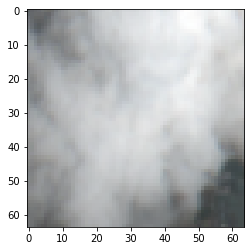

In [26]:
plt.imshow(s2_arr_nonmasked/band_maxes)

### S2 Imagery mosaic with cloud masking

This method has only been implemented against Sentinel 2 data and uses the accompanying Descartes Labs proprietary Sentinel 2 cloud mask product to mask out cloud pixels on a pixelwise basis before creating the mosaic from the remainder.

We can optionally supply a min date and max date. The scenes catalog will be filtered to only include scenes that fall within this date range, if applicable. From the selected scenes the pixelwise Sentinel 2 cloud mask will be applied to mask out cloud pixels. At each pixel (and each band), the mosaic will then be constructed from the **median** of the unmasked values. 

The function returns an ndarray of the retrieved imagery data with shape (Y,X,Z). The z-dimension is equivalent to the number of bands in the retrieved dataset and the datatype is whatever it is in the source data.

In [ ]:
s2_arr_masked = create_cloudmasked_s2_array(test_s2_tile, 
                            min_date=test_s2_min_date, 
                            max_date=test_s2_max_date)
                            

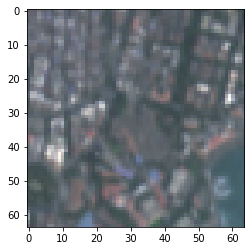

In [35]:
band_maxes=s2_arr_masked.max(axis=(0,1),keepdims=True)
plt.imshow(s2_arr_masked/band_maxes)

### VHR Imagery mosaic and label data for a single tile and date

We'll demonstrate for two places: one with some slum and some non-slum; the other with some non-slum and some nodata

(identified by looking at the tile geoms saved above, and the training data geometries, in GIS)

In [21]:
test_tile = dl.scenes.DLTile.from_key(list(unique_tile_ids)[2000])
#test_tile_with_nd = dl.scenes.DLTile.from_key('252:2:1.0:43:-909:8373')

Test the ndarray creation functions

In [12]:
test_date = date(2017,4,1)
test_product = "airbus:oneatlas:phr:v2"
test_label_info = THIS_RUN_CONFIG.LABEL_DATA()
test_label_ds = test_label_info.OGR_DATASET
test_label_attrib = test_label_info.BURN_ATTRIB
test_label_lyr_idx = test_label_info.get_layer_index()

In [22]:
label_arr = create_label_array_for_tile(test_tile, 
                                        test_label_ds, test_label_attrib, test_label_lyr_idx, 
                                        background_value=255)
img_arr = create_img_array_for_tile(test_tile, test_product, test_date)
label_arr.max()

255

In [24]:
label_arr

array([[  3,   3,   3, ...,   3,   3,   3],
       [  3,   3,   3, ...,   3,   3,   3],
       [  3,   3,   3, ...,   3,   3,   3],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [ ]:
label_arr_with_nd = create_label_array_for_tile(test_tile_with_nd, test_label_ds, test_label_attrib, test_label_lyr_idx, background_value=2)
img_arr_with_nd = create_img_array_for_tile(test_tile_with_nd, test_product, test_date)
label_arr_with_nd.max()

Visualise the data returned

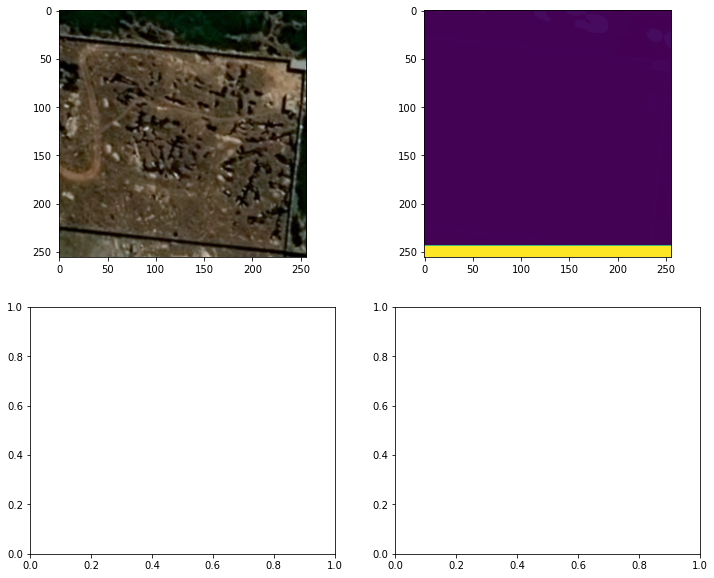

In [23]:
fig, ax = plt.subplots(2,2, figsize=(12,10))
# note that the sentinel data are 16-bit i.e. value range 0-65536, but in this area 
# values are mostly at the lower end, so normalise to 2000 for now with e.g.
# ax[0].imshow(img_arr / 2000.)
# for RGB data no need for this
ax[0][0].imshow(img_arr)
ax[0][1].imshow(label_arr)
#ax[1][0].imshow(img_arr_with_nd)
#ax[1][1].imshow(label_arr_with_nd)


### Create image and label output chips (files) for a single tile 

The above two functions retrieve the data to ndarrays. 

We have also created a wrapper function `create_chips_for_tile` that calls them each and saves the ndarrays to image files (GeoTIFF) on disk, in the necessary folder structure.

The function will call the cloud-masking mosaic function if the requested `max_cloud_fraction == 0` and `product == "sentinel-2:L1C"`. Otherwise it will call the reference-date / cloud fraction based mosaic function.

In [52]:
create_chips_for_tile?

Signature:
create_chips_for_tile(
    job_details: dl_segmentation_utils._descartes_img_chips.DLTileJobConfig,
) -> tuple
Docstring:
Creates image chips (geotiff training samples) for the specified  TileJobConfig.

The image and label data files will be placed into /images and /labels subfolders below 
the specified output folder location, and their name will be the DLTile's key with ':' 
replaced by '#'.

Returns a 3-tuple of (job_details, path_to_image, path_to_label). If the request to the 
Descartes Labs API failed to generate an image, then returns (job_details, None, None). 
In this case, you should re-try several times before concluding that data are not 
available (or check in the DL Viewer), as the API is prone to transient failures.

Function is pickleable so can be used as the task in multiprocessing via joblib etc
File:      c:\users\harry\documents\github\dl_slum_experiments\dl_segmentation_utils\_descartes_img_chips.py
Type:      function


### Test the wrapper function

The wrapper function takes a single DLTileJobConfig parameter, which is a data class containing the necessary info to retrieve a data image, rasterise a label image, and save them both to disk.

In [60]:
from dl_segmentation_utils import DLTileJobConfig
test_images_folder = r'C:\Users\harry\Documents\Data\test'
test_tile_job = DLTileJobConfig.from_run_config(THIS_RUN_CONFIG, 
                                    dltile=test_s2_tile,
                                    out_folder_base=test_images_folder,
                                    ref_date=test_date,
                                    min_date=None, max_date=None, max_cloud_fraction=None
                                    )

In [61]:
create_chips_for_tile(test_tile_job)

C:\Users\harry\anaconda3\envs\dl_tf_gpu\lib\site-packages\descarteslabs\client\services\raster\raster.py:685: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  metadata = json.loads(npz["metadata"].tostring().decode("utf-8"))


(<dl_segmentation_utils._descartes_img_chips.DLTileJobConfig at 0x2b7f07ac848>,
 'C:\\Users\\harry\\Documents\\Data\\test\\images\\60#2#10.0#43#-380#3491.tif',
 'C:\\Users\\harry\\Documents\\Data\\test\\labels\\60#2#10.0#43#-380#3491.tif')

<a id='run_exports'></a>
# Perform the exports! Exporting the samples to geotiff tiles

Let's create training samples for all our tiles, now, using this `create_chips_for_tile` function. 

#### Parallelism

We can do this in multiple processes to run faster. The number of processes we can get away with depends on how fast the DL API responds to a typical request, i.e. how much time each process spends waiting around for a response vs processing and saving the data once retrieved. 

The response time of the DL API in turn depends on the complexity of the mosaic task we're asking it to do. Retrieving a simple nearest-to-date 3-band mosaic from the relatively small number of scenes available in the Pleiades product is much faster than retrieving a cloudmasked composite of 13 bands from the much larger collection of scenes in the S2 collection.

In either case we can almost certainly profit from using more jobs than we have cores. Using a 12-(virtual)core laptop and a decent home broadband connection a good value seems to be 20 jobs in parallel for Pleiades RGB imagery, and 30 jobs in parallel for S2 imagery. 

(For investigation: We could use the Descartes Tasks service to farm this out to *many* machines but it's probably an unnecessary complication at this stage - we'd then have to upload the data from each worker to the DL Storage service, and collate them back in from there at the end. Running on a reasonably decent single machine is fast enough for now).

#### Structure 

We use a simple wrapper class called `DLTileJobJonfig` to allow us to pass the DLTile object in joblib queues (the DLTile is not not otherwise pickleable). And we define a function called `create_chips_for_tile` which runs the export for one `DLTileJobConfig` and saves the resulting image and label image to geotiff files. 

Note that the functions we are using need to be defined in an external file rather than the notebook in order to work reliably with joblib, otherwise it's pretty hard to sort out the scope of them.

Finally we map this `create_chips_for_tile` function over all the `DLTileJobConfig`s, using a simple wrapper function `run_export_for_year` defined in the notebook below. And we call *that* for each set of training data we wish to create; e.g. one for each year the product is available and once for a "nearest-available-but-unrestricted-date" type export.



#### Mosaic creation options

For a given imagery product (e.g. Sentinel-2 SR) and DLTile, we need to define how to create an image mosaic from all the images that are available covering the region of that tile. 

This is a question of filtering by a date range of interest; filtering to remove overall cloudy images and/or individual cloudy pixels; and selecting a value for output at each pixel from the possibly multiple inputs that pass all the criteria.

`create_chips_for_tile` will handle this process, choosing an algorithm for the mosaic creation based on the inputs we give according to the following process:

* If there is more than one product specified, all intersecting scenes will be valid and there is no filtering by date or other prioritisation. (If multiple scenes do overlap, the first one will be used at each pixel, but it's not recommended that this occurs; this approach is intended for single-point-in-time model result retrieval)
* Else if max cloud cover is set as 0 and product is "sentinel-2:L1C" then the intersecting scenes will be filtered by the min and max date, a cloudfree composite will be created on a pixelwise basis by applying the DL cloud mask, and the median value of remaining pixels will be used
  * This is only available for Sentinel data, not airbus. It's probably normally the best option for S2, but not always: e.g. it's slower, it's a median of multiple scenes rather than targeted to a specific date).
* Else the intersecting scenes will be filtered by min/max date iff they are not None. The matching scenes will then be filtered by comparing their overall cloud fraction to the specified cloud fraction iff it is not None. Finally the mosaic will be created by selecting the pixel that is from the scene that is closest in time to the specified reference data.
  * By inspecting the data in the Descartes Labs Viewer, we empirically determine limits for cloud cover fraction to use in the search that will result in a decently-cloud-free mosaic, for each year. (If the limit is set too low, or to zero, then it might result in too few images being usable to make a mosaic at all).

Thus for a given export run, we need to define some combination of the target date for imagery, the min/max date to accept images from, the maximum cloud cover to allow, as well as a string location name to generate the output filenames from. 

e.g. this will create a mosaic from 2017 data only, prioritising scenes closest to 
30th June 2017, and only allowing scenes with less than 10% cloud cover (but not applying pixelwise cloud masking):
``` python
YEAR = 2017
REF_DATE = date(YEAR,6,30)
min_date = date(YEAR,1,1)
max_date = date(YEAR,12,31)                                     
max_cloud_cover = 0.1
_loc="mumbai"
```

If the product is Sentinel-2, this will create a mosaic using the pre-calculated pixelwise cloud mask:
``` python
YEAR = 2017
min_date = date(YEAR,1,1)
max_date = date(YEAR,12,31)                                     
max_cloud_cover = 0
_loc="mumbai"
```


Define all the years we want to export data for and the cloud fraction to use for each year:

In [3]:
# Sentinel 2 exports for every year since 2015 using scene-wise cloud fraction
# filtering with thresholds determined by visual inspection in DL Viewer
sentinel_mumbai_year_cf_pairs = [
    (2015, 0.67),
    (2016, 0.67),
    (2017, 0.10),
    (2018, 0.25),
    (2019, 0.15),
    (2020, 0.40)
]
_loc = "mumbai"

In [4]:
# Sentinel 2 exports for every year since 2015 using pixel-wise cloud masking
sentinel_mumbai_year_cloudmasking_pairs = [
    (2015, 0),
    (2016, 0),
    (2017, 0),
    (2018, 0),
    (2019, 0),
    (2020, 0)
]
_loc = "mumbai"

In [5]:
# Airbus Pleiades exports for every year that reasonable coverage of the AOI 
# is available (determined in DL Viewer); cloud filtering isn't available but as 
# a curated product it is less affected by clouds anyway
airbus_mumbai_year_cf_pairs = [
    (2015, None),
    (2017, None),
    (2018, None),
    (2019, None)
]
_loc = "mumbai"

In [28]:
airbus_other_annual_pairs = [
    (2015, None),
    (2016, None),
    (2017, None),
    (2018, None),
    (2019, None),
    (2020, None)
]
sentinel_other_year_cloudmasking_pairs = [
    (2015, 0),
    (2016, 0),
    (2017, 0),
    (2018, 0),
    (2019, 0),
    (2020, 0)
]
_loc = "nairobi"

## Use multiprocessing to efficiently grab all tiles 


As described above we now define a function `run_export_for_year` to export all the tiles for each year we need them for.

For each year this function will, for each DLTile, create a wrapper TileJobConfig object which also contains the output folder, DL product identifier(s), target date for the mosaicing, the labels dataset, attribute to burn, the index of the labels feature class in the dataset, and the bands to extract from the imagery product.

It will then call `create_chips_for_tile` for each DLTileJobConfig, running in parallel using joblib.

Unfortunately the DL API often has transient failures meaning we sometimes need to try a given tile export multiple times. We define a helper function to check if a job has already been done before actually running it.

In [25]:
from joblib import Parallel, delayed
import multiprocessing
from datetime import date
def is_done(jobconfig):
    fn = jobconfig.DLTILE.key.replace(':','#')
    folder = jobconfig.OUTFOLDER
    outimg = os.path.join(folder, 'images', fn) + ".tif"
    outlbl = os.path.join(folder, 'labels', fn) + ".tif"
    return os.path.exists(outimg) and os.path.exists(outlbl)

def run_export_for_year(base_run_config, year, cf_fraction, loc, restrict_to_year=True):
    base_run_config.MAX_CLOUD_FRACTION = cf_fraction
    year_label=year
    if isinstance(year, int):
        if restrict_to_year:
            ref_date = date(year, 12, 15)
            min_date = date(year, 1, 1)
            max_date = date(year, 12, 31)  
        else:
            ref_date = date(year, 4, 1)
            min_date = None
            max_date = None
            year_label = str(year)+"-closest"
    else:
        ref_date = None
        min_date = None
        max_date = None
    base_run_config.SET_MAX_CLOUD_FRACTION(cf_fraction)
    tile_jobs = base_run_config.create_tile_job_configs(loc_label=loc, year_label=year_label, 
                                                        ref_date=ref_date, 
                                                        min_date=min_date, max_date=max_date)
    
    _out_folder = base_run_config.images_dir_name(loc, year_label)
    print(_out_folder)
    print(f"{len(tile_jobs)} jobs")
    
    tile_jobs = [c for c in tile_jobs if not is_done(c)]
    print(f"  of which {len(tile_jobs)} to run (not already done)")
    
    # create_chips_for_tile will make these folders if they don't exist, but when running 
    # in parallel (multiprocessing as opposed to multithreaded) there is a race condition 
    # when another process makes the folder in between the if-folder-does-not-exist and 
    # then-make-folder statements, leading to it often throwing a "directory exists" 
    # exception on the os.makedirs statement.
    # So make them in the caller first.
    imfolder = os.path.join(_out_folder,"images")
    lbfolder = os.path.join(_out_folder,"labels")
    if not os.path.exists(imfolder):
        os.makedirs(imfolder)
    if not os.path.exists(lbfolder):
        os.makedirs(lbfolder)
    
    # run the jobs in parallel
    res = Parallel(n_jobs=N_JOBS)(delayed(create_chips_for_tile)(t) for t in tile_jobs)
    
    # check for any failures
    allok = len([r for r in res if r[1]==None])==0
    if not allok:
        failed_ids = [r[0].DLTILE.key for r in res if r[1]==None]
        if len(failed_ids)<25:
            print(f"The following {len(failed_ids)} tasks failed for job {_out_folder}:\n {failed_ids}")
        else:
            print(f"{len(failed_ids)} tasks failed for job {_out_folder}")

Before running the parallel export jobs, reduce process priority so we can run at least as many processes as we have cores without compromising usability of the machine while it runs.

Set the priority of the parent (this) process before creating children, and it will inherit, so we don't need to do this in the worker function.

This syntax is for windows, on linux we need to use a numeric value I think

In [29]:
import psutil, os
p = psutil.Process(os.getpid())
print("Priority before: " + str(p.nice()))
p.nice(psutil.IDLE_PRIORITY_CLASS)
print("Priority after: " + str(p.nice()))

Priority before: 0


AttributeError: module 'psutil' has no attribute 'IDLE_PRIORITY_CLASS'

     |████████████████████████████████| 296 kB 5.0 MB/s eta 0:00:01


### Export VHR RGB imagery

With 20 worker processes, Mumbai VHR RGB tiles (c.5795 images) are created in c.25 minutes.

One more level of wrapping: we wrap the call to `run_export_for_year` in a hacky retry loop so it keeps plugging away when the DL API returns transient errors resulting in an exception. This seems to happen sometimes if a request times out, which it can do at busy times. `run_export_for_year` is idempotent and will skip over any jobs where the output already exists so when the API returns an error the easiest thing is to just re-try.

If this reports incomplete tiles, it's still worth re-running this too as the DL API can also fail by not returning data without rasing an exception.


In [ ]:
THIS_RUN_CONFIG = IC_VHR_SAMPLE_CONFIG
N_JOBS = 30

In [ ]:
for yr, frac in airbus_other_annual_pairs:
    for attempt in range(20):
        try:
            run_export_for_year(THIS_RUN_CONFIG, yr, frac, _loc)
        except:
            #raise
            print("swallowed exception")
        else:
            break



In [ ]:
#  closest-available mosaic targeted on 2020 
# (i.e. not restricted to only 2020 data)
for attempt in range(20):
        try:
            run_export_for_year(THIS_RUN_CONFIG, 2020, None, "nairobi", False)
        except:
            print("swallowed exception")
        else:
            break

If the logs above show any tasks as having failed even after 20 retries, then simply re-run the cell, many times if necessary, until they all go through ok or the number of failures stops decreasing. You might need to re-try another day to be sure. Check the AOI and year in the DL Viewer webapp to be sure that data really do not exist as opposed to being a DL API problem.

### Export Sentinel multispectral imagery 

For the Sentinel imagery with many more images available in the collection, the DL API response is much slower, we can up the number of jobs to 30 on a 12 core machine to speed things up.

In [98]:
THIS_RUN_CONFIG = IC_LR_SAMPLE_CONFIG # IC_LR_SAMPLE_CONFIG
N_JOBS = 30

In [ ]:
for yr, frac in sentinel_other_year_cloudmasking_pairs:
    for attempt in range(20):
        try:
            run_export_for_year(THIS_RUN_CONFIG, yr, frac, _loc)
        except:
            print("swallowed exception")
        else:
            break



As with the VHR imagery (or more so) keep re-running if any failures occur.

### Export results from previous model runs into new training data

Here "year" is not relevant as there is no date filtering so use a string identifier instead; and cloud filtering is not relevant as these are predicted model outputs so use None to turn it off.

In [32]:
N_JOBS=20
run_export_for_year(THIS_RUN_CONFIG, 2017, None, "lusaka", False)

/mnt/c/Users/harry/Documents/Data/airbus_50cm_0.5m_4pad_256_lusaka_2017-closest
3444 jobs
  of which 4 to run (not already done)


In [30]:
run_export_for_year?

Signature:
run_export_for_year(
    base_run_config,
    year,
    cf_fraction,
    loc,
    restrict_to_year=True,
)
Docstring: <no docstring>
File:      /mnt/c/Users/harry/Documents/github/dl_image_segmentation/<ipython-input-25-358a08a3f865>
Type:      function
